
# 🔧 하이퍼파라미터 튜닝 

머신러닝 모델에는 **설정값(파라미터)** 들이 있다.  
예: 트리의 깊이, 학습 속도 등이다.

이 설정을 조금씩 바꿔보면서 **가장 좋은 조합**을 찾는 과정을 말한다.

- `GridSearch`: 가능한 모든 경우를 다 시험해봄  
- `RandomSearch`: 랜덤으로 여러 경우를 뽑아 시험해봄



## 1) 하이퍼파라미터 튜닝이란 무엇인가?

- 하이퍼파라미터는 **모델의 설정값**이다. 예: 트리의 깊이(`max_depth`), 학습률(`learning_rate`) 등이다.  
- 튜닝은 이 설정을 바꾸어 **성능이 가장 좋은 조합**을 찾는 과정이다.  
- 잘못된 설정은 **과적합**(외우기) 또는 **과소적합**(너무 단순)을 만든다. 올바른 설정은 **일반화 성능**을 높인다.



## 2) 교차검증과 함께 설계하기

- 튜닝은 보통 **Stratified K-Fold** 같은 교차검증과 함께 진행한다.  
- **누수 방지 원칙:** 각 폴드의 **학습 부분**에서만 전처리·재표본화·피처선정을 수행하고,
같은 폴드의 **검증 부분**에 적용한다.  
- 최종 모델 선택 후에는 **원본 분포의 테스트 세트**에서 한 번만 평가한다.



## 3) 탐색 방법 요약

| 방법 | 개념 | 장점 | 단점 | 추천 상황 |
|---|---|---|---|---|
| GridSearchCV | 값 목록의 **모든 조합**을 탐색 | 완전탐색 | 계산량 큼 | 후보가 적거나 마지막 미세 조정 |
| RandomizedSearchCV | 범위/분포에서 **무작위 샘플** | 빠름, 넓게 탐색 | 최적값 보장 X | 초반에 넓게 살피기 |
| (참고) 베이지안 최적화 | 다음 탐색 지점을 똑똑하게 고름 | 효율적 | 별도 라이브러리 | 시간이 제한될 때 유용 |

> 실무 팁: **RandomizedSearch → GridSearch** 순서가 효율적이다.



## 4) 검증곡선(Validation Curve)으로 파라미터 감각 익히기

한 파라미터를 바꾸면서 교차검증 점수를 그리면  
**과소적합 ↔ 적정 ↔ 과적합** 영역을 직관적으로 볼 수 있다.

아래 예시는 `DecisionTreeClassifier`의 `max_depth`를 바꿔가며 **F1**(양성 기준) 점수를 본다.


## 1. `validation_curve`란 무엇인가?

`validation_curve`는 **특정 하이퍼파라미터가 모델 성능에 어떤 영향을 주는지** 분석하기 위한 도구이다.

- 하이퍼파라미터 값을 여러 개 준비한다.
- 각 값에 대해 모델을 학습하고, **훈련 점수(train score)**와 **검증 점수(validation score)**를 계산한다.
- 이 점수들을 그래프로 나타내어, 하이퍼파라미터 값에 따라 모델이 **과소적합인지, 적정인지, 과적합인지**를 시각적으로 확인할 수 있다.

즉, `validation_curve`는 **하이퍼파라미터 튜닝의 방향을 잡아주는 탐색 도구**이다.

## 2. 기본적인 함수 개념

`validation_curve`의 개념적인 함수 형태는 다음과 같다:

- `estimator` : 사용할 모델 객체 (예: `DecisionTreeClassifier`, `RandomForestClassifier`, `SVC` 등)
- `X`, `y` : 특징(feature)과 타깃(target) 데이터
- `param_name` : 튜닝하고 싶은 하이퍼파라미터 이름 (문자열)
- `param_range` : 해당 하이퍼파라미터에 대해 실험할 값들의 목록 (list 또는 array)
- `cv` : 교차검증에서 몇 개의 fold로 나눌지
- `scoring` : 성능 지표 (예: `accuracy`, `f1`, `roc_auc` 등)
- `n_jobs` : 병렬 처리에 사용할 CPU 코어 수 (보통 `-1`로 전체 사용)

함수를 호출하면, 하이퍼파라미터 값별로 **훈련 점수 배열**과 **검증 점수 배열**을 반환한다.

## 3. 주요 파라미터 설명

### 🔹 `estimator`
- 학습시킬 모델 객체이다.
- 예: `DecisionTreeClassifier(random_state=42)`, `RandomForestClassifier()`, `SVC()` 등

### 🔹 `X`, `y`
- `X` : 입력 데이터 (2차원 배열 또는 DataFrame)
- `y` : 타깃 값 (1차원 배열 또는 Series)

### 🔹 `param_name`
- 튜닝하려는 하이퍼파라미터의 이름을 문자열로 적는다.
- 예: `"max_depth"`, `"n_estimators"`, `"C"`, `"gamma"` 등
- Pipeline을 사용할 경우에는 `"단계이름__파라미터"` 형식으로 쓴다. (예: `"model__max_depth"`)

### 🔹 `param_range`
- 해당 하이퍼파라미터에 대해 시도해볼 값들의 목록이다.
- 예: 깊이 조정 →  `1, 2, 3, ..., 20`
- 예: 규제 강도 C → `0.01, 0.1, 1, 10, 100` 등 로그 스케일을 자주 사용

### 🔹 `cv`
- K-Fold 교차검증에서의 `K` 값이다. (예: 5라면 5-Fold)
- 데이터가 적을수록 `cv`를 크게 설정하면 모델 평가가 더 안정적이지만 학습 시간이 늘어난다.

### 🔹 `scoring`
- 사용할 평가 지표 이름을 문자열로 지정한다.
- 분류: `"accuracy"`, `"precision"`, `"recall"`, `"f1"`, `"roc_auc"` 등
- 회귀: `"r2"`, `"neg_mean_squared_error"` 등

### 🔹 `n_jobs`
- CPU 병렬 처리 옵션이다.
- `-1`로 설정하면 가능한 모든 코어를 사용한다.

## 4. 반환값: `train_scores`, `val_scores` 해석

`validation_curve`는 보통 두 개의 2차원 배열을 반환한다.

- `train_scores` : 각 하이퍼파라미터 값에 대해, 교차검증의 각 fold마다 계산된 **훈련 점수**
- `val_scores`   : 각 하이퍼파라미터 값에 대해, 교차검증의 각 fold마다 계산된 **검증 점수**

각 배열의 구조는 대략 다음과 같다.

- 행(row) : 서로 다른 하이퍼파라미터 값 (`param_range`의 원소)
- 열(column) : 각 fold (cv 개수만큼)

실전에서는 보통 다음과 같은 통계치를 사용한다.

- `train_scores`의 각 행에 대해 평균 → **훈련 평균 점수**
- `val_scores`의 각 행에 대해 평균 → **검증 평균 점수**
- 필요하면 표준편차(std)도 계산해 에러바(error bar)로 시각화할 수 있다.

이 평균 점수들을 x축에 `param_range`, y축에 점수(accuracy 등)를 두고 선 그래프로 그리면, **하이퍼파라미터 값 vs. 성능 곡선(Validation Curve)**를 얻을 수 있다.

## 5. 예시 시나리오: DecisionTree의 `max_depth` 튜닝 (개념 설명)

예를 들어, 유방암 데이터셋 같은 이진 분류 데이터를 사용하고, `DecisionTreeClassifier`의 `max_depth`를 튜닝한다고 가정하자.

1. `max_depth`를 1부터 20까지 바꾸어가며 모델을 학습한다.
2. 각 깊이에 대해 5-Fold 교차검증을 수행한다.
3. 각 깊이마다 **훈련 정확도(train accuracy)**와 **검증 정확도(validation accuracy)**의 평균을 구한다.
4. x축에 `max_depth`, y축에 점수를 두고 두 개의 곡선을 그린다.
    - 하나는 훈련 점수 곡선
    - 하나는 검증 점수 곡선

그래프는 보통 다음과 같은 패턴을 보이게 된다.

- 작은 깊이 (`max_depth`가 1~2일 때):
  - 훈련 점수도 낮고, 검증 점수도 낮다.
  - 모델이 너무 단순해서 **과소적합(underfitting)** 상태이다.

- 어느 중간 깊이 (예: 4~6 정도):
  - 훈련 점수는 꽤 높고, 검증 점수도 가장 높은 지점 근처에 있다.
  - **일반화 성능이 가장 좋은 구간**이다.

- 너무 큰 깊이 (예: 15 이상):
  - 훈련 점수는 거의 1.0(100%)에 가깝다.
  - 하지만 검증 점수는 떨어지기 시작한다.
  - 훈련 데이터에 너무 맞춰져 **과적합(overfitting)**이 발생한 상태이다.

## 6. Validation Curve 그래프 해석 포인트

`validation_curve`의 그래프를 볼 때, 다음 세 가지 구간을 구분해서 생각하면 좋다.

### 1) 과소적합 구간 (Underfitting)
- 훈련 점수도 낮고, 검증 점수도 낮다.
- 모델이 너무 단순하거나, 제약이 너무 강한 경우에 나타난다.
- 예: `max_depth`가 너무 작은 결정트리, `C`가 지나치게 작은 SVM 등

### 2) 적정 복잡도 구간 (Best Region)
- 훈련 점수는 적당히 높다.
- 검증 점수가 가장 높은 지점 근처이다.
- 이 구간이 **일반화 성능이 가장 좋은 하이퍼파라미터 후보**이다.

### 3) 과적합 구간 (Overfitting)
- 훈련 점수는 매우 높다 (거의 1.0 등).
- 그러나 검증 점수는 점점 떨어지거나 변동이 커진다.
- 모델이 너무 복잡해져서 훈련 데이터의 노이즈까지 외워버린 상태이다.

실무에서는 보통 **검증 점수가 최대가 되는 지점 또는 그 근처의 단순한 모델**을 선택하는 것이 좋다.

## 7. `validation_curve`를 사용하는 이유

1. **하이퍼파라미터 영향 파악**
   - 특정 하이퍼파라미터가 커질수록/작아질수록 모델이 어떻게 변하는지 직관적으로 알 수 있다.
   - 예: `max_depth`를 늘리면 처음에는 좋아지다가 나중에는 과적합된다는 패턴을 확인할 수 있다.

2. **과적합 vs 과소적합 진단**
   - 훈련/검증 점수 곡선을 동시에 봄으로써, 현재 모델이 과적합 상태인지, 과소적합 상태인지 진단할 수 있다.

3. **GridSearchCV 범위 설정에 도움**
   - 전체 후보 범위를 대략적으로 탐색한 후, 괜찮아 보이는 범위 안에서 `GridSearchCV`나 `RandomizedSearchCV`로 세밀하게 튜닝할 수 있다.

4. **여러 모델 비교에 활용 가능**
   - 같은 데이터에 대해 서로 다른 모델(SVM, 결정트리, 랜덤포레스트 등)별 validation curve를 그려보며, 어떤 모델이 더 적합한지도 감을 잡을 수 있다.

## 8. 자주 사용하는 하이퍼파라미터 + Validation Curve 조합

모델별로 `validation_curve`에 자주 사용하는 파라미터 예시는 다음과 같다.

| 모델 | 추천 하이퍼파라미터 |
|------|-----------------------|
| `DecisionTreeClassifier` | `max_depth`, `min_samples_split`, `min_samples_leaf` |
| `RandomForestClassifier` | `n_estimators`, `max_depth`, `max_features` |
| `GradientBoostingClassifier` / `XGBClassifier` / `LGBMClassifier` | `n_estimators`, `learning_rate`, `max_depth` |
| `KNeighborsClassifier` | `n_neighbors`, `p`(거리 척도) |
| `SVC` | `C`, `gamma` (특히 RBF 커널 사용 시) |

이러한 하이퍼파라미터는 모델의 **복잡도(규제 강도)**와 직결되는 경우가 많아, `validation_curve`로 확인했을 때 과적합/과소적합 패턴이 잘 드러나는 편이다.

## 9. 정리

1. `validation_curve`는 **하이퍼파라미터 값에 따른 훈련/검증 성능 변화**를 시각화해 주는 도구이다.
2. 이를 통해 **과적합/과소적합 여부를 직관적으로 확인**할 수 있다.
3. 검증 점수가 최대가 되는 지점 또는 그 근처가 **좋은 후보 하이퍼파라미터**이다.
4. `GridSearchCV` 전에 범위를 좁히는 용도로 사용하면 매우 효율적이다.
5. 결정트리, 랜덤포레스트, SVM, 부스팅 모델, KNN 등 다양한 모델에 적용 가능하다.

이 노트북은 개념 설명에 초점을 맞췄으므로, 실습을 하고 싶다면 별도의 코드 노트북(예: `validation_curve_tutorial.ipynb`)과 함께 사용하는 것을 추천한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
import koreanize_matplotlib
from utils import ohe_transform

In [2]:
data = pd.read_csv("./data/salary2.csv")
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
data = data.drop_duplicates()
data = data.dropna()
data = data.reset_index(drop=True)
data['class'] = data['class'].apply(lambda x: 1 if x == ' >50K' else 0)
data['class'].value_counts()
X = data.drop('class', axis=1)
y = data['class']

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=10)

In [6]:
X_train, X_test = ohe_transform(X_train, X_test)

In [7]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    make_scorer, f1_score,
    precision_recall_curve, average_precision_score, auc,
    roc_curve, roc_auc_score)

In [8]:
param_range = np.arange(1, 21)  # 1~20
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

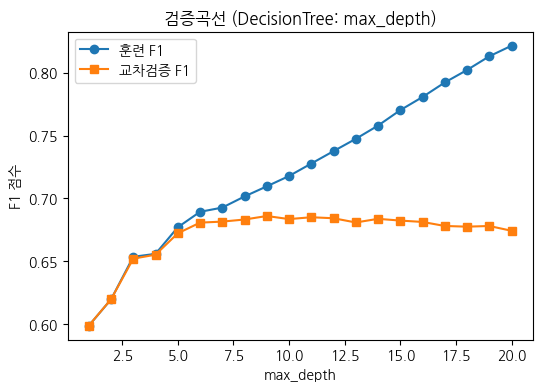

In [9]:
# 검증곡선: max_depth 변화 vs F1 점수
train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    X_train, y_train, param_name="max_depth", param_range=param_range,
    cv=cv, scoring=make_scorer(f1_score)
)

# 평균 점수 계산
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

# 단일 플롯 (색상 지정 없음)
plt.figure(figsize=(6,4))
plt.plot(param_range, train_mean, marker="o", label="훈련 F1")
plt.plot(param_range, val_mean, marker="s", label="교차검증 F1")
plt.title("검증곡선 (DecisionTree: max_depth)")
plt.xlabel("max_depth")
plt.ylabel("F1 점수")
plt.legend()
plt.show()


# 🌳 검증곡선 해석 (DecisionTree: `max_depth`)

---

## 🔍 1. 그래프 구성 요소

| 항목 | 설명 |
|------|------|
| **x축 (`max_depth`)** | 의사결정나무의 최대 깊이 — 모델 복잡도를 조절하는 하이퍼파라미터 |
| **y축 (F1 점수)** | 정밀도(precision)와 재현율(recall)을 함께 고려한 조화평균 |
| **파란선 (●)** | 훈련 데이터의 F1 점수 |
| **주황선 (■)** | 교차검증 데이터(검증 데이터)의 F1 점수 |

---

## 🧠 2. 그래프 해석 단계별

### (1) `max_depth`가 작을 때 (1~3)
- **훈련 F1**도 낮고, **교차검증 F1**도 낮음  
→ 모델이 너무 단순하여 데이터의 패턴을 충분히 학습하지 못함  
→ **과소적합(underfitting)** 상태

---

### (2) `max_depth`가 4~6일 때
- **훈련 F1**과 **교차검증 F1**이 모두 상승  
- 두 점수가 비슷하고 안정적임  
→ 모델이 적절한 복잡도를 가지며 일반화가 잘 되는 구간  
→ **최적 복잡도(Sweet Spot)**

---

### (3) `max_depth`가 커질수록 (10 이상)
- **훈련 F1**은 계속 상승 (훈련 데이터 완벽하게 맞춤)
- **교차검증 F1**은 점점 하락 (새로운 데이터에는 약함)  
→ **과적합(overfitting)** 발생

---

## ⚖️ 3. 종합 결론

- 최적의 `max_depth`는 **약 5~7** 부근  
- 이 구간에서 훈련/검증 F1이 모두 높고, 차이도 작음  
- 그 이후로는 복잡도 증가에 따라 과적합 심화

---

## 💡 4. 실무적 시사점

| 상황 | 의미 | 대응 전략 |
|------|------|------------|
| 훈련 F1 < 교차검증 F1 | 데이터 부족 또는 과도한 정규화 | 모델 복잡도 ↑ |
| 훈련 F1 ≈ 교차검증 F1 | 좋은 일반화 상태 | ✅ 최적 상태 |
| 훈련 F1 ≫ 교차검증 F1 | 과적합 발생 | 가지치기, `max_depth` 축소, `min_samples_leaf` 증가 |

---

## 📈 5. 요약

> `max_depth`를 늘릴수록 훈련 성능은 좋아지지만,  
> 일정 수준 이후에는 교차검증 성능이 떨어지며 **일반화 능력 저하**가 발생한다.  
> 따라서 **훈련/검증 성능이 균형 잡힌 지점**이 가장 좋은 `max_depth`이다.



## 5) 학습곡선(Learning Curve)으로 데이터/모델 한계 파악

훈련 데이터 양을 늘려가며 **훈련/검증 성능**이 어떻게 변하는지 보면,  
- **데이터를 더 모아야 하는지**,  
- **모델 용량(복잡도)을 바꿔야 하는지**를 알 수 있다.


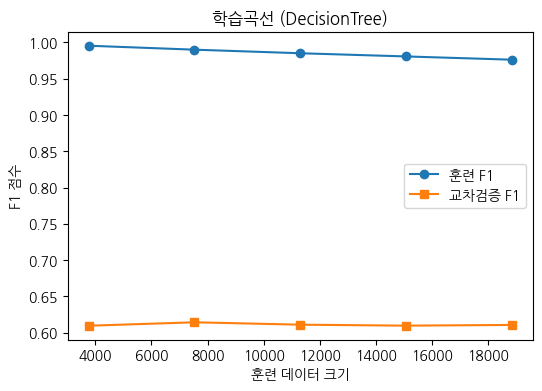

In [10]:
train_sizes, train_scores, val_scores = learning_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    X_train, y_train, cv=cv, scoring=make_scorer(f1_score),
    train_sizes=np.linspace(0.2, 1.0, 5), shuffle=True, random_state=42
)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="훈련 F1")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="s", label="교차검증 F1")
plt.title("학습곡선 (DecisionTree)")
plt.xlabel("훈련 데이터 크기")
plt.ylabel("F1 점수")
plt.legend()
plt.show()


# 📊 학습곡선(DecisionTree) 해석

---

## 🔍 1. 그래프 구성 요소

| 항목 | 설명 |
|------|------|
| **x축** | 훈련 데이터의 크기 (훈련 샘플 수 증가) |
| **y축** | F1 점수 (정밀도와 재현율의 조화 평균) |
| **파란선 (●)** | 훈련 데이터에 대한 F1 점수 |
| **주황선 (■)** | 교차검증 데이터(검증 데이터)에 대한 F1 점수 |

---

## 🧠 2. 그래프 해석 단계별

### (1) 훈련 데이터 크기가 작을 때 (~4000)
- **훈련 F1**은 거의 1.0 (거의 완벽한 예측)
- **교차검증 F1**은 약 0.6 수준으로 매우 낮음  
→ 모델이 훈련 데이터에만 완벽히 맞춰지고, 새로운 데이터에는 성능이 낮음  
→ **심한 과적합(overfitting)** 상태

---

### (2) 훈련 데이터가 점점 많아질 때 (4000 → 18000)
- **훈련 F1**은 약간 감소 (모델이 다양한 데이터에 노출되며 완벽히 외우기 어려워짐)
- **교차검증 F1**은 거의 변화 없음 (여전히 낮은 수준 유지)  
→ 데이터가 많아져도 일반화 성능이 개선되지 않음  
→ 즉, **모델 구조 자체가 단순히 과적합되는 경향**을 보임

---

## ⚖️ 3. 종합 결론

| 구분 | 내용 |
|------|------|
| **훈련 성능** | 매우 높음 (F1 ≈ 1.0) |
| **검증 성능** | 매우 낮음 (F1 ≈ 0.6) |
| **훈련/검증 간 간극** | 매우 큼 → **과적합 심각** |
| **결론** | 데이터의 크기보다 모델의 복잡도 제어(`max_depth`, `min_samples_leaf`)가 필요 |

---

## 💡 4. 개선 방향

| 문제 원인 | 해결 전략 |
|------------|------------|
| 의사결정나무가 너무 복잡함 | `max_depth` 줄이기 |
| 일부 노드에 데이터 과소 분할 | `min_samples_split`, `min_samples_leaf` 증가 |
| 데이터 불균형 | `class_weight='balanced'` 옵션 사용 |
| 단일 트리의 한계 | 배깅(RandomForest), 부스팅(LightGBM, XGBoost) 활용 |

---

## 📈 5. 요약

> 훈련 데이터 크기를 늘려도 교차검증 성능이 향상되지 않는 것은  
> 모델이 **데이터 복잡도에 비해 지나치게 복잡**하기 때문이다.  
> 즉, **DecisionTree는 현재 과적합 상태**이며,  
> **하이퍼파라미터 튜닝 또는 앙상블 기법 적용**이 필요하다.



## 6) 어떤 지표로 튜닝할까?

- 불균형 데이터이면 **F1, Recall, PR-AUC**를 권장한다.  
- 비용 민감 문제라면, 업무 비용에 맞춰 **임계값**을 별도로 조정한다.  
- ROC-AUC만 높고 PR-AUC가 낮다면, **희소 양성 문제**일 가능성이 크다.


=== Hold-out 지표 요약 ===
ROC-AUC = 0.737 | PR-AUC = 0.650 | AP = 0.468 | 양성비율(기준선) = 0.254


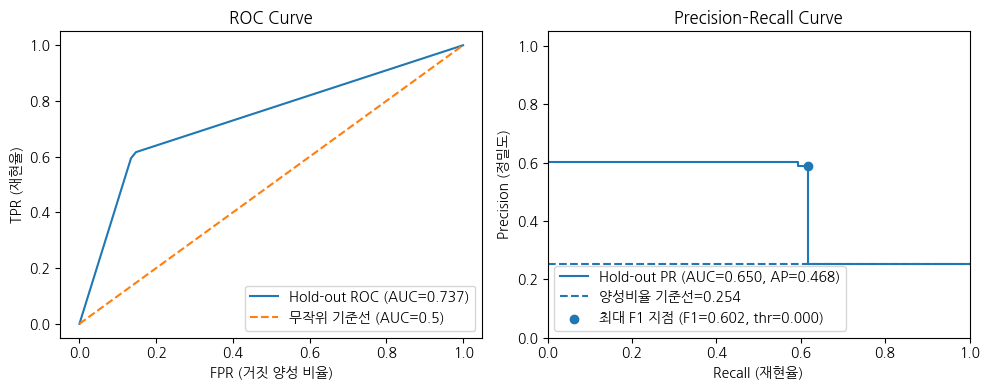

In [11]:
# =========================
# 2) Hold-out용 PR 변수들 계산 (반드시 ROC/PR 전에 정의)
# =========================
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train, y_train)

# 예측 확률(양성 클래스)
y_score = dt.predict_proba(X_test)[:, 1]

# PR-curve, PR-AUC(AP), 기준선
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc = auc(recall, precision)
ap = average_precision_score(y_test, y_score)
baseline = (y_test == 1).mean()

# 최대 F1 지점
f1_vals = 2 * precision * recall / (precision + recall + 1e-12)
best_idx = int(np.nanargmax(f1_vals))
best_recall = recall[best_idx]
best_precision = precision[best_idx]
best_f1 = f1_vals[best_idx]
best_threshold = thresholds[max(0, best_idx - 1)]  # thresholds 길이 보정

# =========================
# 3) ROC-AUC vs PR-AUC 비교 (Hold-out + 선택: CV) - 안전한 포맷팅/플로팅
# =========================
from sklearn.metrics import roc_curve, roc_auc_score

def fmt3(x):
    return f"{x:.3f}" if x is not None else "N/A"

# --- Hold-out ROC ---
roc_auc = roc_auc_score(y_test, y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)

print("=== Hold-out 지표 요약 ===")
print(f"ROC-AUC = {roc_auc:.3f} | PR-AUC = {pr_auc:.3f} | AP = {ap:.3f} | 양성비율(기준선) = {baseline:.3f}")

# (선택) CV 기반 ROC/PR도 y_score_cv가 있을 때만 계산
roc_auc_cv = None
try:
    if 'y_score_cv' in locals():
        roc_auc_cv = roc_auc_score(y_train, y_score_cv)
        fpr_cv, tpr_cv, _ = roc_curve(y_train, y_score_cv)
        # pr_auc_cv, ap_cv 는 앞의 try 블록에서 이미 계산됐을 수도 있고 없을 수도 있음
except Exception as e:
    print(f"[INFO] CV ROC-curve는 건너뜀: {e}")

# --- 2열 비교 그림: (좌) ROC, (우) PR ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# (좌) ROC Curve
axes[0].plot(fpr, tpr, label=f"Hold-out ROC (AUC={roc_auc:.3f})")
axes[0].plot([0, 1], [0, 1], linestyle="--", label="무작위 기준선 (AUC=0.5)")
if (roc_auc_cv is not None) and ('fpr_cv' in locals()):
    axes[0].plot(fpr_cv, tpr_cv, label=f"CV ROC (AUC={fmt3(roc_auc_cv)})")
axes[0].set_xlabel("FPR (거짓 양성 비율)")
axes[0].set_ylabel("TPR (재현율)")
axes[0].set_title("ROC Curve")
axes[0].legend(loc="lower right")

# (우) Precision–Recall Curve
axes[1].step(recall, precision, where="post",
             label=f"Hold-out PR (AUC={pr_auc:.3f}, AP={ap:.3f})")
axes[1].hlines(baseline, 0, 1, linestyles="--",
               label=f"양성비율 기준선={baseline:.3f}")

# CV PR곡선: precision_cv/recall_cv가 있고, pr_auc_cv/ap_cv가 계산된 경우만
if ('precision_cv' in locals()) and ('recall_cv' in locals()):
    label_cv = f"CV PR (AUC={fmt3(pr_auc_cv)}, AP={fmt3(ap_cv)})"
    axes[1].step(recall_cv, precision_cv, where="post", label=label_cv)

axes[1].scatter([best_recall], [best_precision], marker="o", zorder=5,
                label=f"최대 F1 지점 (F1={best_f1:.3f}, thr={best_threshold:.3f})")
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.05])
axes[1].set_xlabel("Recall (재현율)")
axes[1].set_ylabel("Precision (정밀도)")
axes[1].set_title("Precision–Recall Curve")
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()


# 📊 ROC-AUC & PR-AUC 그래프 해석

---

## 🔍 1. 전체 요약

| 지표 | 값 | 의미 |
|------|------|------|
| **ROC-AUC** | **0.737** | 모델이 무작위보다 훨씬 나은 구분 능력을 가짐 |
| **PR-AUC** | **0.650** | 양성(1) 클래스에 대한 정밀도-재현율 균형이 중간 수준 |
| **AP (Average Precision)** | **0.468** | 전체 임계값에서 평균 정밀도 |
| **양성 비율 (기준선)** | **0.254** | 데이터에서 실제 양성 클래스 비율 (25.4%) |
| **최대 F1 지점** | **F1 = 0.602, threshold = 0.000** | 가장 균형 잡힌 정밀도/재현율 지점 |

---

## 🧠 2. ROC Curve (왼쪽 그래프)

- **TPR(재현율)** vs **FPR(거짓 양성 비율)** 그래프  
- **파란 실선**: 모델의 ROC 곡선  
- **주황 점선**: 무작위 분류기의 기준선 (AUC = 0.5)

### 해석:
- ROC-AUC = **0.737** → 모델이 **양성과 음성을 73.7% 확률로 올바르게 구분**  
- 완벽한 모델(AUC=1.0)과 무작위 모델(AUC=0.5) 사이에 위치  
- **중간 이상 수준의 분류 성능**, 다만 완벽하지 않음  
- 모델이 과적합되지 않았지만, 개선 여지가 있음

---

## 📈 3. Precision-Recall Curve (오른쪽 그래프)

- **x축:** Recall (재현율, 실제 양성 중 맞춘 비율)  
- **y축:** Precision (정밀도, 예측한 양성 중 실제 양성 비율)

### 주요 특징:
- **파란 실선:** 모델의 Precision-Recall 곡선  
- **파란 점:** 최대 F1 점수 지점 (F1 = 0.602)  
- **파란 점선:** 데이터의 양성 비율(0.254)을 나타내는 기준선

### 해석:
- 모델의 **PR-AUC = 0.650** → 불균형 데이터 환경에서 준수한 수준  
- **기준선(0.254)**보다 훨씬 높으므로, **양성 클래스 식별 능력**이 있음  
- 하지만 **정밀도(Precision)**가 낮고 **재현율(Recall)**이 높은 형태로,  
  **양성을 많이 잡지만 오탐도 많을 가능성** 존재

---

## ⚖️ 4. 종합 결론

| 평가 항목 | 분석 |
|------------|------|
| **ROC-AUC (0.737)** | 모델이 전반적으로 양성과 음성을 잘 구분함 |
| **PR-AUC (0.650)** | 불균형 데이터에서도 양호한 수준 |
| **F1 (0.602)** | Precision과 Recall의 균형이 적당함 |
| **개선 방향** | Precision 향상(오탐 감소)을 위한 threshold 조정 또는 모델 튜닝 필요 |

---

## 💡 5. 실무적 시사점

- **ROC-AUC**은 전체 구분 능력, **PR-AUC**은 양성 클래스 탐지 능력에 초점  
- 데이터 불균형이 심할 때는 **PR-AUC를 우선적으로 해석**해야 함  
- 만약 “양성을 놓치면 안 되는” 문제(예: 사기 탐지, 질병 진단)라면  
  → **Recall을 높이고**, Precision 저하를 감수할 수 있음  
- 반대로 “오탐이 위험한” 문제(예: 금융 승인, 알람 시스템)라면  
  → **Precision 중심 조정(threshold ↑)** 필요

---

## 🧾 6. 요약 문장

> ROC-AUC=0.737, PR-AUC=0.650으로,  
> 모델은 무작위보다 훨씬 좋은 분류 성능을 보이지만  
> 여전히 **양성 클래스 예측의 정밀도 개선 여지**가 있다.  
> 현재 상태는 **균형 잡힌 중간 수준 모델**로 평가할 수 있다.


## 7) 하이퍼파라미터 튜닝 RandomSearchCV, GridSearchCV

## RandomizedSearchCV 개념 & 특징

### ✅ RandomizedSearchCV란?

- **탐색할 파라미터 범위**를 미리 지정해두면,  
  그 안에서 **일정 횟수(`n_iter`)**만큼 **랜덤하게 조합을 뽑아서** 성능을 평가하는 방법이다.

---

### ✅ 장점

- **파라미터 조합이 많을 때** 빠르게 좋은 조합을 찾기 좋다.
- 모든 조합을 다 보지는 않지만,  
  **시간 대비 효율(성능/시간 비율)이 좋다.**
- 연속형 분포(예: `uniform`, `randint`)에서도 샘플링 가능해서  
  **넓은 범위를 대략적으로 탐색**할 때 유리하다.

---

### ✅ 단점

- **모든 조합을 탐색하지 않기 때문에**,  
  이론적으로는 **진짜 최적 조합**을 놓칠 수도 있다.
- `n_iter`를 너무 작게 잡으면  
  탐색이 **불충분**해서 성능 향상이 제한될 수 있다.

---


## 8) 알고리즘별 파라미터 세팅 요령 (실무 요약)

### 8.1 DecisionTreeClassifier
- **핵심:** 트리 깊이·리프 크기로 과적합을 억제한다.
- 주요 파라미터
  - `max_depth`: 트리 최대 깊이. 3~12에서 시작한다.
  - `min_samples_split`: 분할 최소 샘플 수. 2, 5, 10, 20.
  - `min_samples_leaf`: 리프 최소 샘플 수. 1, 2, 5, 10.
  - `class_weight`: 불균형이면 `'balanced'`.
- 스타터 그리드(예시)
  ```python
  {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10]
  }
  ```

### 8.2 RandomForestClassifier
- **핵심:** 충분한 트리 수 + 깊이/리프 제어로 안정화한다.
- 주요 파라미터
  - `n_estimators`: 300~1000에서 시작한다.
  - `max_depth`: 8~30 또는 None.
  - `min_samples_split`, `min_samples_leaf`: 2~20 범위.
  - `max_features`: "sqrt", 0.5, 0.7 등(특성 수에 따라 조정).
  - `class_weight`: 불균형이면 `'balanced'`.
- 스타터 그리드(예시)
  ```python
  {
    "n_estimators": [300, 500, 800],
    "max_depth": [None, 10, 15, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", None]
  }
  ```

### 8.3 XGBoost (XGBClassifier)
- **핵심:** 깊이/학습률/규제로 과적합을 관리하고, 불균형은 `scale_pos_weight`로 보정한다.
- 주요 파라미터
  - `n_estimators`: 300~1000(early_stopping과 함께).
  - `learning_rate`: 0.02~0.2.
  - `max_depth`: 3~10.
  - `min_child_weight`: 1~10.
  - `subsample`, `colsample_bytree`: 0.6~1.0.
  - `reg_alpha`(L1), `reg_lambda`(L2): 0~10.
  - `scale_pos_weight`: (음성 수 / 양성 수) 근사값.
- 스타터 그리드(예시)
  ```python
  {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 5, 7, 9],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 1.0],
    "reg_lambda": [1.0, 3.0, 5.0]
  }
  ```

### 8.4 LightGBM (LGBMClassifier)
- **핵심:** 잎 수와 리프 최소 데이터, 학습률/규제가 중요하다. 불균형은 `is_unbalance` 또는 `class_weight`로 처리한다.
- 주요 파라미터
  - `num_leaves`: 31~127에서 시작한다.
  - `max_depth`: -1(None) 또는 5~20.
  - `learning_rate`: 0.02~0.2.
  - `n_estimators`: 300~1000.
  - `min_data_in_leaf`: 20~100.
  - `feature_fraction`, `bagging_fraction`, `bagging_freq`: 0.6~1.0 / 0.6~1.0 / 0~5.
  - `lambda_l1`, `lambda_l2`: 0~10.
  - `is_unbalance=True` 또는 `class_weight`: 둘을 동시에 쓰지는 않는다.
- 스타터 그리드(예시)
  ```python
  {
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 7, 11, 15],
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "min_data_in_leaf": [20, 40, 80],
    "feature_fraction": [0.7, 0.9, 1.0],
    "bagging_fraction": [0.7, 0.9, 1.0],
    "bagging_freq": [0, 1, 3],
    "lambda_l1": [0, 0.1, 1.0],
    "lambda_l2": [0, 0.1, 1.0]
  }
  ```

### 8.5 CatBoost (CatBoostClassifier)
- **핵심:** 카테고리 자동 처리가 강점이다. 불균형은 `class_weights`로 조정한다.
- 주요 파라미터
  - `iterations`(=n_estimators): 300~1000.
  - `learning_rate`: 0.03~0.2.
  - `depth`: 4~10.
  - `l2_leaf_reg`: 1~10.
  - `subsample`: 0.6~1.0.
  - `class_weights`: [w_neg, w_pos] 형태(비율 역수 근사).
- 스타터 그리드(예시)
  ```python
  {
    "iterations": [300, 600, 1000],
    "learning_rate": [0.03, 0.05, 0.1],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "subsample": [0.7, 0.9, 1.0]
  }
  ```



## 9) 클래스 불균형 대응 요약

| 알고리즘 | 권장 설정 요약 |
|---|---|
| DecisionTree / RandomForest | `class_weight='balanced'` |
| XGBoost | `scale_pos_weight ≈ 음성수/양성수` |
| LightGBM | `is_unbalance=True` 또는 `class_weight` |
| CatBoost | `class_weights=[w_neg, w_pos]` |

> `scale_pos_weight`와 `class_weight` 류는 보통 **동시에 중복 사용하지 않는다**.


In [12]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# StratifiedKFold와 기준 지표 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# 1) DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_dist = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10]
}
dt_rand = RandomizedSearchCV(dt, dt_dist, n_iter=15, cv=cv, scoring=scorer, n_jobs=-1, random_state=42)
dt_rand.fit(X_train, y_train)
# ✅ 최적 하이퍼파라미터 출력
print("🔹 최적 하이퍼파라미터 조합(best_params_):")
print(dt_rand.best_params_)

# ✅ 교차검증 평균 점수 출력
print("\n🔹 교차검증 평균 점수(best_score_):")
print(round(dt_rand.best_score_, 4))

# ✅ 최적 모델 객체 가져오기
best_dt_model = dt_rand.best_estimator_
print("\n🔹 최적 모델 객체:")
print(best_dt_model)

🔹 최적 하이퍼파라미터 조합(best_params_):
{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 9}

🔹 교차검증 평균 점수(best_score_):
0.6857

🔹 최적 모델 객체:
DecisionTreeClassifier(class_weight='balanced', max_depth=9,
                       min_samples_split=5, random_state=42)
🔹 테스트셋 정확도 (accuracy): 0.8036

🔹 분류 보고서 (classification_report):

              precision    recall  f1-score   support

           0       0.94      0.79      0.86     11706
           1       0.58      0.84      0.69      3990

    accuracy                           0.80     15696
   macro avg       0.76      0.82      0.77     15696
weighted avg       0.85      0.80      0.81     15696



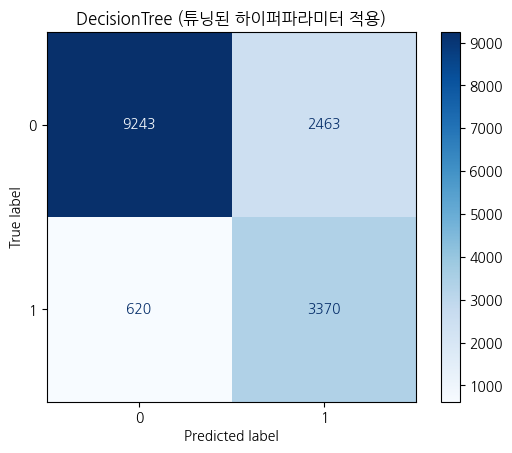

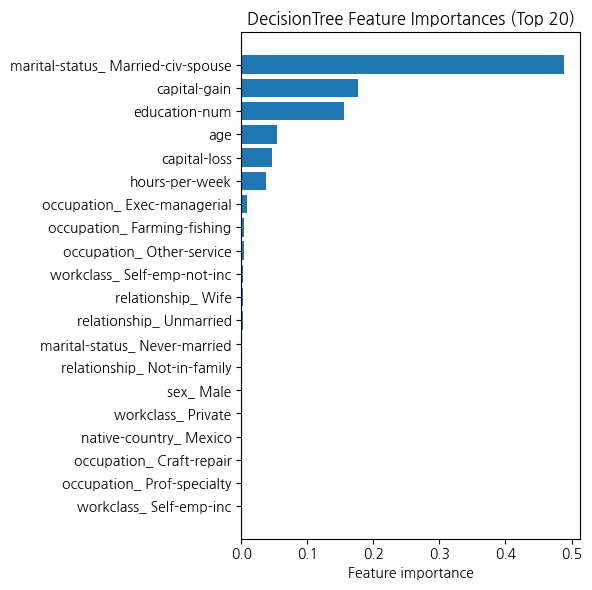

In [13]:
# ✅ 1. 최적 하이퍼파라미터 적용한 모델 생성
best_params = {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 9}
dt_best = DecisionTreeClassifier(
    class_weight='balanced'
    random_state=42,
    **best_params
)

# ✅ 2. 모델 재학습
dt_best.fit(X_train, y_train)

# ✅ 3. 예측 수행
y_pred = dt_best.predict(X_test)

# ✅ 4. 주요 성능 지표 출력
print("🔹 테스트셋 정확도 (accuracy):", round(accuracy_score(y_test, y_pred), 4))
print("\n🔹 분류 보고서 (classification_report):\n")
print(classification_report(y_test, y_pred))

# ✅ 5. 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("DecisionTree (튜닝된 하이퍼파라미터 적용)")
plt.show()

# (선택) ✅ 6) 특성 중요도 상위 20개 시각화
if hasattr(dt_best, "feature_importances_"):
    importances = dt_best.feature_importances_
    # 특성 이름이 있으면 사용, 없으면 인덱스로 대체
    try:
        feature_names = X_train.columns
    except Exception:
        feature_names = np.array([f"f{i}" for i in range(len(importances))])

    idx = np.argsort(importances)[-20:]  # 상위 20개
    plt.figure(figsize=(6, max(4, len(idx) * 0.3)))
    plt.barh(range(len(idx)), importances[idx])
    plt.yticks(range(len(idx)), feature_names[idx])
    plt.xlabel("Feature importance")
    plt.title("DecisionTree Feature Importances (Top 20)")
    plt.tight_layout()
    plt.show()

# 2) RandomForest

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
%%time
# ✅ 1. 모델과 탐색 범위 정의
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_dist = {
    "n_estimators": [300, 500, 800, 1000],
    "max_depth": [None, 10, 15, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", None]
}

# ✅ 2. 랜덤 탐색 실행
rf_rand = RandomizedSearchCV(
    rf, rf_dist,
    n_iter=20,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    random_state=42
)
rf_rand.fit(X_train, y_train)

# ✅ 3. 최적 하이퍼파라미터 및 교차검증 점수 출력
print("🔹 최적 하이퍼파라미터 조합(best_params_):")
print(rf_rand.best_params_)

print("\n🔹 교차검증 평균 점수(best_score_):")
print(round(rf_rand.best_score_, 4))

# ✅ 4. 최적 모델로 재학습
best_rf_model = rf_rand.best_estimator_
best_rf_model.fit(X_train, y_train)

# ✅ 5. 테스트 데이터로 예측
y_pred = best_rf_model.predict(X_test)

# ✅ 6. 평가 지표 출력
print("\n🔹 테스트셋 정확도 (accuracy):", round(accuracy_score(y_test, y_pred), 4))
print("\n🔹 분류 보고서 (classification_report):\n")
print(classification_report(y_test, y_pred))

# ✅ 7. 혼동행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("RandomForest (튜닝된 하이퍼파라미터 적용)")
plt.show()

# (선택) ✅ 6) 특성 중요도 상위 20개 시각화
if hasattr(best_rf_model, "feature_importances_"):
    importances = best_rf_model.feature_importances_
    # 특성 이름이 있으면 사용, 없으면 인덱스로 대체
    try:
        feature_names = X_train.columns
    except Exception:
        feature_names = np.array([f"f{i}" for i in range(len(importances))])

    idx = np.argsort(importances)[-20:]  # 상위 20개
    plt.figure(figsize=(6, max(4, len(idx) * 0.3)))
    plt.barh(range(len(idx)), importances[idx])
    plt.yticks(range(len(idx)), feature_names[idx])
    plt.xlabel("Feature importance")
    plt.title("RandomForest Feature Importances (Top 20)")
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

# 3) XGBoost

C:\Users\haram4th\miniforge3\envs\test_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [08:44:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 최적 하이퍼파라미터 조합(best_params_):
{'subsample': 0.9, 'reg_lambda': 5.0, 'reg_alpha': 0, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 0.7}

🔹 교차검증 평균 점수(best_score_):
0.726


C:\Users\haram4th\miniforge3\envs\test_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [08:44:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 테스트셋 정확도 (accuracy): 0.8332

🔹 분류 보고서 (classification_report):

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     11706
           1       0.62      0.86      0.72      3990

    accuracy                           0.83     15696
   macro avg       0.79      0.84      0.80     15696
weighted avg       0.86      0.83      0.84     15696



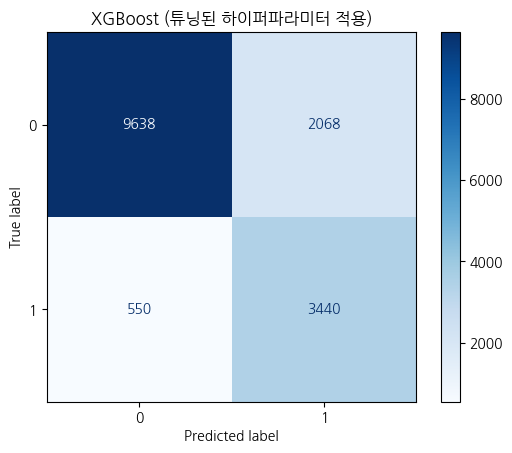

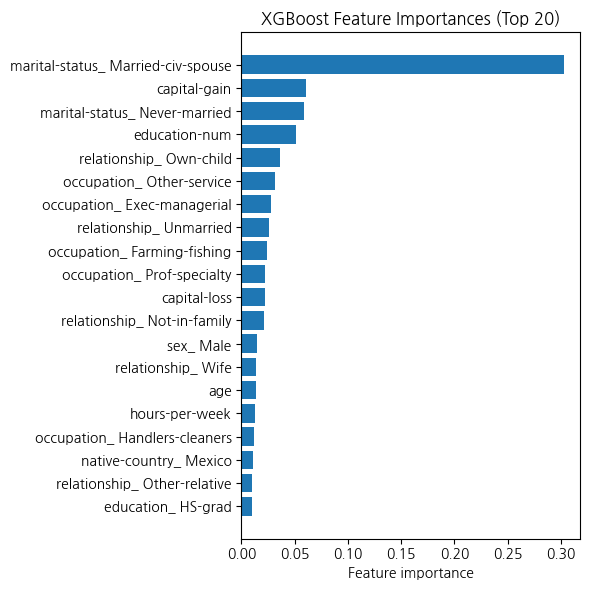

CPU times: total: 36 s
Wall time: 1min 6s


In [16]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# ✅ 1) 불균형 비율 계산 (훈련 데이터 기준)
ratio = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

# ✅ 2) 기본 모델 정의
xgb = XGBClassifier(
    tree_method="hist",
    eval_metric="logloss",
    scale_pos_weight=ratio,
    random_state=42,
    verbose=2
)

# ✅ 3) 탐색할 파라미터 범위 정의
xgb_dist = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 5, 7, 9],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 1.0],
    "reg_lambda": [1.0, 3.0, 5.0]
}

# ✅ 4) RandomizedSearchCV 실행
xgb_rand = RandomizedSearchCV(
    xgb,
    xgb_dist,
    n_iter=25,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    random_state=42
)
xgb_rand.fit(X_train, y_train)

# ✅ 5) 최적 파라미터 및 교차검증 점수 출력
print("🔹 최적 하이퍼파라미터 조합(best_params_):")
print(xgb_rand.best_params_)

print("\n🔹 교차검증 평균 점수(best_score_):")
print(round(xgb_rand.best_score_, 4))

# ✅ 6) 최적 모델로 재학습
best_xgb_model = xgb_rand.best_estimator_
best_xgb_model.fit(X_train, y_train)

# ✅ 7) 테스트 데이터로 예측
y_pred = best_xgb_model.predict(X_test)

# ✅ 8) 성능 평가
print("\n🔹 테스트셋 정확도 (accuracy):", round(accuracy_score(y_test, y_pred), 4))
print("\n🔹 분류 보고서 (classification_report):\n")
print(classification_report(y_test, y_pred))

# ✅ 9) 혼동행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("XGBoost (튜닝된 하이퍼파라미터 적용)")
plt.show()

# (선택) ✅ 6) 특성 중요도 상위 20개 시각화
if hasattr(best_xgb_model, "feature_importances_"):
    importances = best_xgb_model.feature_importances_
    # 특성 이름이 있으면 사용, 없으면 인덱스로 대체
    try:
        feature_names = X_train.columns
    except Exception:
        feature_names = np.array([f"f{i}" for i in range(len(importances))])

    idx = np.argsort(importances)[-20:]  # 상위 20개
    plt.figure(figsize=(6, max(4, len(idx) * 0.3)))
    plt.barh(range(len(idx)), importances[idx])
    plt.yticks(range(len(idx)), feature_names[idx])
    plt.xlabel("Feature importance")
    plt.title("XGBoost Feature Importances (Top 20)")
    plt.tight_layout()
    plt.show()


# 4) LightGBM

🔹 최적 하이퍼파라미터 조합(best_params_):
{'num_leaves': 127, 'n_estimators': 300, 'min_data_in_leaf': 80, 'max_depth': 7, 'learning_rate': 0.05, 'lambda_l2': 1.0, 'lambda_l1': 1.0, 'feature_fraction': 0.7, 'bagging_freq': 0, 'bagging_fraction': 0.7}

🔹 교차검증 평균 점수(best_score_):
0.7237

🔹 테스트셋 정확도 (accuracy): 0.8303

🔹 분류 보고서 (classification_report):

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     11706
           1       0.62      0.86      0.72      3990

    accuracy                           0.83     15696
   macro avg       0.78      0.84      0.80     15696
weighted avg       0.86      0.83      0.84     15696



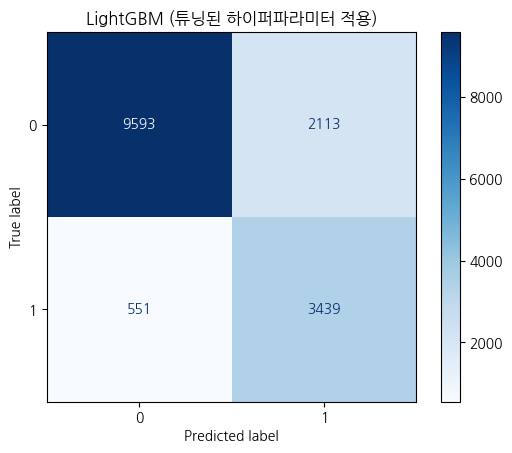

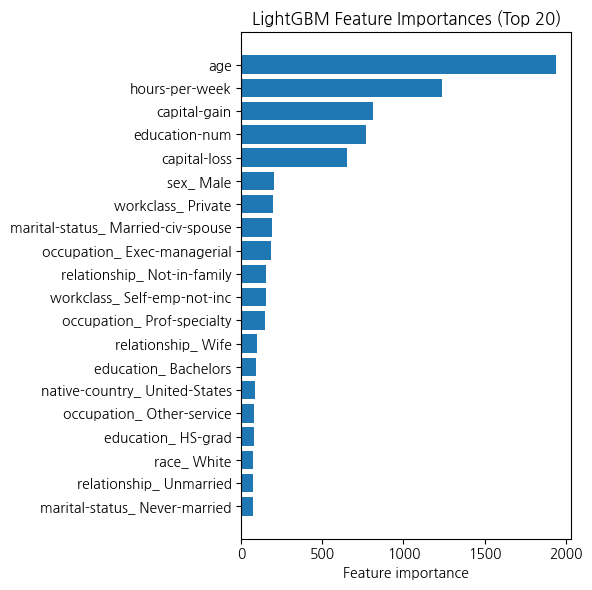

CPU times: total: 5.98 s
Wall time: 2min 6s


In [19]:
%%time
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(objective="binary", random_state=42, is_unbalance=True, verbose=-1)
lgbm_dist = {
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 7, 11, 15],
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "min_data_in_leaf": [20, 40, 80],
    "feature_fraction": [0.7, 0.9, 1.0],
    "bagging_fraction": [0.7, 0.9, 1.0],
    "bagging_freq": [0, 1, 3],
    "lambda_l1": [0, 0.1, 1.0],
    "lambda_l2": [0, 0.1, 1.0]
}
lgbm_rand = RandomizedSearchCV(lgbm, lgbm_dist, n_iter=25, cv=cv, scoring=scorer, n_jobs=-1, random_state=42)
lgbm_rand.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# ✅ 1) 최적 하이퍼파라미터 및 교차검증 점수 출력
print("🔹 최적 하이퍼파라미터 조합(best_params_):")
print(lgbm_rand.best_params_)

print("\n🔹 교차검증 평균 점수(best_score_):")
print(round(lgbm_rand.best_score_, 4))

# ✅ 2) 최적 모델로 재학습
best_lgbm_model = lgbm_rand.best_estimator_
best_lgbm_model.fit(X_train, y_train)

# ✅ 3) 테스트 데이터 예측
y_pred = best_lgbm_model.predict(X_test)

# ✅ 4) 성능 평가 출력
print("\n🔹 테스트셋 정확도 (accuracy):", round(accuracy_score(y_test, y_pred), 4))
print("\n🔹 분류 보고서 (classification_report):\n")
print(classification_report(y_test, y_pred))

# ✅ 5) 혼동행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("LightGBM (튜닝된 하이퍼파라미터 적용)")
plt.show()

# (선택) ✅ 6) 특성 중요도 상위 20개 시각화
if hasattr(best_lgbm_model, "feature_importances_"):
    importances = best_lgbm_model.feature_importances_
    # 특성 이름이 있으면 사용, 없으면 인덱스로 대체
    try:
        feature_names = X_train.columns
    except Exception:
        feature_names = np.array([f"f{i}" for i in range(len(importances))])

    idx = np.argsort(importances)[-20:]  # 상위 20개
    plt.figure(figsize=(6, max(4, len(idx) * 0.3)))
    plt.barh(range(len(idx)), importances[idx])
    plt.yticks(range(len(idx)), feature_names[idx])
    plt.xlabel("Feature importance")
    plt.title("LightGBM Feature Importances (Top 20)")
    plt.tight_layout()
    plt.show()


# 5) CatBoost

Fitting 5 folds for each of 20 candidates, totalling 100 fits
🔹 최적 하이퍼파라미터 조합(best_params_):
{'subsample': 0.7, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 600, 'depth': 6}

🔹 교차검증 평균 점수(best_score_):
0.7135

🔹 테스트셋 정확도 (accuracy): 0.8653

🔹 분류 보고서 (classification_report):

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     11706
           1       0.78      0.66      0.71      3990

    accuracy                           0.87     15696
   macro avg       0.83      0.80      0.81     15696
weighted avg       0.86      0.87      0.86     15696



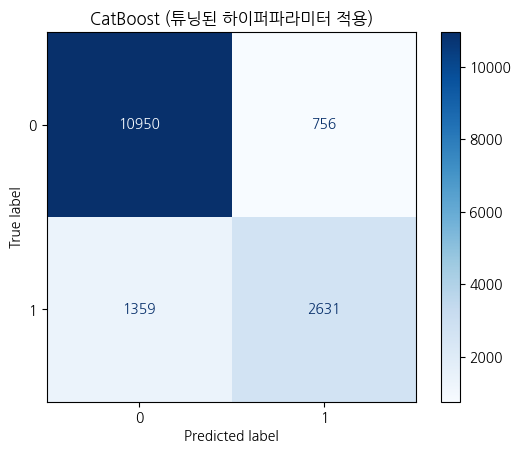

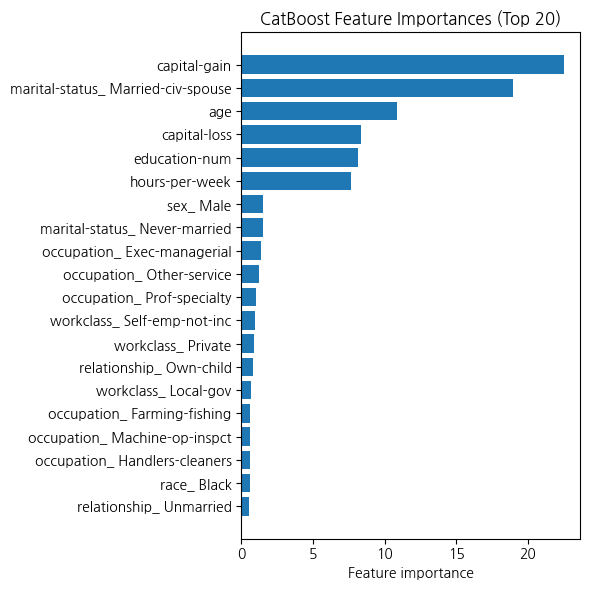

CPU times: total: 1min 29s
Wall time: 8min 16s


In [20]:
%%time
from catboost import CatBoostClassifier
cb = CatBoostClassifier(verbose=0, random_state=42)
cb_dist = {
    "iterations": [300, 600, 1000],
    "learning_rate": [0.03, 0.05, 0.1],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "subsample": [0.7, 0.9, 1.0]
}
cb_rand = RandomizedSearchCV(cb, cb_dist, n_iter=20, cv=cv, scoring=scorer, n_jobs=-1, random_state=42, verbose=2)
cb_rand.fit(X_train, y_train)

# ✅ 1) 최적 하이퍼파라미터 및 교차검증 점수 출력
print("🔹 최적 하이퍼파라미터 조합(best_params_):")
print(cb_rand.best_params_)

print("\n🔹 교차검증 평균 점수(best_score_):")
print(round(cb_rand.best_score_, 4))

# ✅ 2) 최적 모델로 재학습 (필요시 eval_set/early_stopping도 추가 가능)
best_cb_model = cb_rand.best_estimator_
best_cb_model.fit(X_train, y_train, verbose=0)

# ✅ 3) 테스트 데이터 예측
y_pred = best_cb_model.predict(X_test)

# ✅ 4) 성능 평가 출력
print("\n🔹 테스트셋 정확도 (accuracy):", round(accuracy_score(y_test, y_pred), 4))
print("\n🔹 분류 보고서 (classification_report):\n")
print(classification_report(y_test, y_pred))

# ✅ 5) 혼동행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("CatBoost (튜닝된 하이퍼파라미터 적용)")
plt.show()

# (선택) ✅ 6) 특성 중요도 상위 20개 시각화
try:
    # CatBoost 전용 중요도: get_feature_importance (학습된 모델 필요)
    importances = best_cb_model.get_feature_importance()
    try:
        feature_names = X_train.columns
    except Exception:
        feature_names = np.array([f"f{i}" for i in range(len(importances))])

    idx = np.argsort(importances)[-20:]  # 상위 20개
    plt.figure(figsize=(6, max(4, len(idx) * 0.3)))
    plt.barh(range(len(idx)), np.array(importances)[idx])
    plt.yticks(range(len(idx)), np.array(feature_names)[idx])
    plt.xlabel("Feature importance")
    plt.title("CatBoost Feature Importances (Top 20)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"[INFO] 중요도 계산을 건너뜀: {e}")

## GridSearchCV 개념 & 특징

### ✅ GridSearchCV란?

- 사용자가 지정한 **모든 하이퍼파라미터 조합을 전부 탐색**하는 방법이다.  
- 즉, 각 파라미터마다 후보 값들을 격자(grid)처럼 나열해 두고,  
  그 **모든 조합을 하나씩 다 학습 + 평가**한다.

---

### ✅ 장점

- 지정한 후보 집합 내에서는  
  **“완전 탐색(브루트 포스)”**을 하기 때문에  
  그 범위 안에서 **최적 조합을 놓치지 않는다.**
- 파라미터 수와 후보 개수가 **적당히 적다면**,  
  해석과 재현성이 좋다.

---

### ✅ 단점

- 파라미터 개수와 후보 값 개수가 조금만 늘어나도  
  **조합 수가 기하급수적으로 증가**한다.  
  - 예: 파라미터 3개, 각각 후보 10개 → 10 × 10 × 10 = 1000조합
- 모델 학습 비용이 큰 경우,  
  **시간이 너무 많이 걸릴 수 있다.**
- 넓은 범위를 탐색하기에는 **비효율적**이며,  
  보통은 **“좁고 정교한 범위”**에 적합하다.

# GridSearchCV 예제 Lightgbm

In [24]:
%%time
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    make_scorer, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
import numpy as np

# 🔹 F1 스코어 기준 지표 (이미 위에서 scorer 정의했다면 생략 가능)
scorer = make_scorer(f1_score)

# 1) 기본 LightGBM 모델
lgbm = LGBMClassifier(
    objective="binary",
    random_state=42,
    is_unbalance=True
)

# 2) GridSearch용 파라미터 그리드
lgbm_grid = {
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 7, 11, 15],
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "min_data_in_leaf": [20, 40, 80],
    "feature_fraction": [0.7, 0.9, 1.0],
    "bagging_fraction": [0.7, 0.9, 1.0],
    "bagging_freq": [0, 1, 3],
    "lambda_l1": [0, 0.1, 1.0],
    "lambda_l2": [0, 0.1, 1.0],
    "verbose" : [-1]
}

# ⚠️ 조합 수가 매우 많으므로 실제 실행 시 시간 오래 걸릴 수 있음
lgbm_gs = GridSearchCV(
    estimator=lgbm,
    param_grid=lgbm_grid,   # ✅ param_distributions → param_grid
    cv=cv,                  # StratifiedKFold
    scoring=scorer,         # f1 기준
    n_jobs=-1
)

# 3) 그리드 서치 학습
lgbm_gs.fit(X_train, y_train)

# ✅ 1) 최적 하이퍼파라미터 및 교차검증 점수 출력
print("🔹 [GridSearch] 최적 하이퍼파라미터 조합 (best_params_):")
print(lgbm_gs.best_params_)

print("\n🔹 [GridSearch] 교차검증 평균 점수 (best_score_):")
print(round(lgbm_gs.best_score_, 4))

# ✅ 2) 최적 모델로 재학습 (사실 best_estimator_는 이미 학습되어 있음)
best_lgbm_model = lgbm_gs.best_estimator_
best_lgbm_model.fit(X_train, y_train)

# ✅ 3) 테스트 데이터 예측
y_pred = best_lgbm_model.predict(X_test)

# ✅ 4) 성능 평가 출력
print("\n🔹 테스트셋 정확도 (accuracy):", round(accuracy_score(y_test, y_pred), 4))
print("\n🔹 분류 보고서 (classification_report):\n")
print(classification_report(y_test, y_pred))

# ✅ 5) 혼동행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("LightGBM (GridSearchCV 튜닝 적용)")
plt.show()

# (선택) ✅ 6) 특성 중요도 상위 20개 시각화
if hasattr(best_lgbm_model, "feature_importances_"):
    importances = best_lgbm_model.feature_importances_
    try:
        feature_names = X_train.columns
    except Exception:
        feature_names = np.array([f"f{i}" for i in range(len(importances))])

    idx = np.argsort(importances)[-20:]  # 상위 20개
    plt.figure(figsize=(6, max(4, len(idx) * 0.3)))
    plt.barh(range(len(idx)), importances[idx])
    plt.yticks(range(len(idx)), feature_names[idx])
    plt.xlabel("Feature importance")
    plt.title("LightGBM Feature Importances (Top 20)")
    plt.tight_layout()
    plt.show()


KeyboardInterrupt: 

# Microsoft FLAML
https://microsoft.github.io/FLAML/
* Microsoft가 만든 가볍고 빠른 AutoML 도구
* (= 모델 선택 + 하이퍼파라미터 튜닝을 자동으로 해주는 라이브러리)

# LAML의 장점(한 줄 요약)

* 빠르다 → 다른 AutoML보다 훨씬 빠름
* 가볍다 → CPU만으로도 충분
* 저비용 → 불필요한 탐색을 거의 안 함
* 자동화 → 모델 선택 + 파라미터 튜닝까지 자동

# 사용가능 분석 종류

* 분류(Classification)
* 회귀(Regression)
* 시계열 예측(Forecasting)
* NLP (HuggingFace 기반)
* 모델 하이퍼파라미터 튜닝(HPO)

# FLAML이 자동으로 해주는 것

* LightGBM, XGBoost, LR 등 어떤 모델이 좋은지 자동 선택
* 하이퍼파라미터 자동 튜닝
* 교차검증 수행
* 가장 좋은 모델을 자동 저장

# 단점: 정교한 제어가 어렵다

* FLAML은 자동화가 강점인데, 그래서“세세한 튜닝(모델 설정, 파라미터 범위)”을 직접 컨트롤하기는 어려움.
* → 전문가가 아주 정밀하게 최적화할 때는 GridSearch가 더 적합.

In [22]:
# !pip install flaml

In [23]:
# (필요 시) !pip install flaml
from flaml import AutoML

# ===============================
# 🔟-추가) FLAML AutoML 베이스라인
# ===============================
print("\n🚀 FLAML AutoML 학습 중...")

automl = AutoML()
automl.fit(
    X_train, y_train,
    task="classification",
    time_budget=60,                 # ⏱️ 총 탐색 시간(초) - 상황에 맞게 조절
    metric="accuracy",               # 평가지표(불균형이면 'f1'/'roc_auc' 권장)
    eval_method="cv",                # 교차검증
    n_splits=3,
    estimator_list=["lgbm", "xgboost", "rf", "extra_tree"],  # 설치된 환경에 맞춰 사용
    verbose=1
)

print("\n✅ FLAML Best Estimator:", automl.best_estimator)
print("✅ FLAML Best Config:", automl.best_config)
print("✅ FLAML Best Loss:", automl.best_loss)

y_pred_flaml = automl.predict(X_test)
acc_flaml = accuracy_score(y_test, y_pred_flaml)
print(f"✅ FLAML 정확도: {acc_flaml:.4f}")
print(classification_report(y_test, y_pred_flaml))

# 기존 결과 dict에 추가
results['FLAML'] = acc_flaml


ModuleNotFoundError: No module named 'flaml'


## 10) 튜닝 체크리스트

- [ ] 지표 선택: F1/Recall/PR-AUC 등 문제 성격과 일치하는가  
- [ ] 교차검증 설계: Stratified/Group/TimeSeries 등 상황에 맞는가  
- [ ] 누수 방지: 폴드 학습 안에서만 전처리/재표본화/피처선정 수행  
- [ ] 탐색 전략: Randomized → Grid로 효율적 탐색  
- [ ] 과적합 방지: 깊이/리프/규제/서브샘플링 조정  
- [ ] 불균형 처리: class_weight/scale_pos_weight/is_unbalance/class_weights 적용  
- [ ] 임계값/캘리브레이션: 필요 시 점수 보정/운영점 최적화  
- [ ] 최종 검증: 원본 분포의 테스트 세트에서 단 한 번 확인
